# Efeito do financiamento na quantidade de votos

Vamos aplicar a teoria de grafos causais do Judea Pearl, mais especificamente a fórmula do ajuste do critério backdoor, à pergunta: 
qual o efeito causal do tamanho do financiamento de campanha eleitoral nos votos obtidos nas eleições?

## Preliminares

Pacotes de python utilizados:

In [59]:
!git clone https://github.com/hsxavier/xavy.git
!git clone https://github.com/cewebbr/brass.git

Cloning into 'xavy'...
remote: Enumerating objects: 143, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 143 (delta 83), reused 135 (delta 75), pack-reused 0 (from 0)
Receiving objects: 100% (143/143), 178.67 KiB | 1.96 MiB/s, done.
Resolving deltas: 100% (83/83), done.


Descomprimindo dados:

In [ ]:
!gzip -d dados.tar.gz
!tar -xvf dados.tar

## Funções

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl

import xavy.dataframes as xd
import xavy.explore as xe
import xavy.utils as xu
import xavy.plots as xp

In [2]:
def gen_intervention_data(df, do_values):
    """
    Create a synthetic dataset in which every instance is 
    replicated for each specified value of the do variables.

    Parameters
    ----------
    df : DataFrame
        Original, real dataset.
    do_values : dict of list-likes
        Keys are the variables we will intervene on. The values
        are like of values we will force them to assume.

    Returns
    -------
    out_df : DataFrame
        The cross join between the specified values in `do_values` 
        and the remaining features in the dataset.
    """

    out_df = df.copy()
    
    # Loop over do-variables:
    for k in do_values.keys():

        # Create 'intervention' data:
        v = do_values[k]
        v_series = pd.Series(v).repeat(len(df))
        v_series.index = np.concatenate([df.index] * len(v))
        v_series.name = k
    
        # Replace do variable with 'intervention' values:
        out_df = out_df.drop(k, axis=1)
        out_df = out_df.join(v_series)

    return out_df


def adjustment_predict_intervention(model, X_df, do_var, do_values):
    """
    Predict the effect of intervening on a variable by setting
    it to the specified values, using the adjustment formula.

    Parameters
    ----------
    model : sklearn predictor
        A model for the target variable already fitted and 
        ready to predict. It must expect as input the do 
        feature plus all features whose conditioning is 
        required to estimate the causal effect of the do
        variable.
    X_df : DataFrame
        The independent variables (features) used in the 
        prediction. It must include the do variable plus all
        features we are conditioning on. The instances must 
        follow the true distribution of the data in the feature
        space.
    do_var : str
        Name of the variable to intervene on. It must 
        be one of the features in `X_df`.
    do_values : list-like
        Do variable values for which to evaluate the 
        target value.

    Returns
    -------
    marg_y_preds : Series
        Estimate of the average causal effect of the do 
        variable on the target variable.
    """
    
    # Generate synthetic data:
    doX_df = gen_intervention_data(X_df, {do_var: do_values})
    # Predict for all data:
    all_y_preds = model.predict(doX_df)
    # Take the average for each do value:
    doX = doX_df[do_var].values
    marg_y_preds = pd.Series(all_y_preds).groupby(doX).mean()

    return marg_y_preds 

## Carregando os dados

**Notas**

* Deputados federais podem gastar até R\\$ 2,5M, enquanto deputados estaduais só podem gastar R\\$ 1,0M. Vamos focar num cargo só para tornar os dados mais homogêneos.
* Vamos usar deputados estaduais, que são mais numerosos.
* [Normas do TSE](https://www.tse.jus.br/++theme++justica_eleitoral/pdfjs/web/viewer.html?file=https://www.tse.jus.br/comunicacao/arquivos/limites-de-gastos-2022/@@download/file/647%20-%20ANEXO.pdf) sobre valores máximos de campanha.

### Perfil dos candidatos

In [3]:
# Carrega dados completos:
raw_cand18_df = pd.read_csv('../dados/limpos/consulta_cand_2018_BRASIL.csv', encoding='latin-1', sep=';', low_memory=False)
raw_cand22_df = pd.read_csv('../dados/limpos/consulta_cand_2022_BRASIL.csv', low_memory=False)

In [4]:
# Faz recorte dos dados:
sel_cargos = ['DEPUTADO ESTADUAL']
prev_cargos = ['DEPUTADO FEDERAL', 'DEPUTADO ESTADUAL']

# Seleciona dados de 2018:
cand18_df = raw_cand18_df.copy()
cand18_df = cand18_df.loc[cand18_df['DS_CARGO'].isin(prev_cargos) & ~cand18_df['DS_GENERO'].isin(['NÃO DIVULGÁVEL'])]

# Seleciona dados de 2022:
cand22_df = raw_cand22_df.copy()
cand22_df = cand22_df.loc[cand22_df['DS_CARGO'].isin(sel_cargos) & ~cand22_df['DS_GENERO'].isin(['NÃO DIVULGÁVEL'])]
print('# candidatos a {:} em 2022: {:}'.format(', '.join(sel_cargos), len(cand22_df)))

# candidatos a DEPUTADO ESTADUAL em 2022: 16232


### Quantidade de votos recebidos

In [5]:
# Carrega votos por candidato:
votos18_df = pd.read_csv('../dados/processados/votos_por_candidato_2018.csv', index_col=0).rename({'QT_VOTOS_NOMINAIS':'QT_VOTOS_NOMINAIS_18'}, axis=1)
votos22_df = pd.read_csv('../dados/processados/votos_por_candidato_2022.csv', index_col=0).rename({'QT_VOTOS_NOMINAIS':'QT_VOTOS_NOMINAIS_22'}, axis=1)

### Receitas em 2022

In [6]:
receitas_df = pd.read_csv('../dados/processados/receita_por_candidato_2022.csv', index_col=0)

### Selecionando candidatos presentes nas duas eleições

In [7]:
# Candidatos presentes nas duas eleições:
# PS: existem candidatos registrados mais de uma vez, i.e. com mais de um SQ_CANDIDATO (mas são poucos)
cand_cols_22 = ['NR_CPF_CANDIDATO', 'SQ_CANDIDATO', 'NM_URNA_CANDIDATO', 'NM_CANDIDATO', 'SG_PARTIDO', 'SG_UF', 'DS_GENERO']
cand_cols_18 = ['SQ_CANDIDATO', 'NR_CPF_CANDIDATO', 'DS_COR_RACA']
both_df = cand22_df[cand_cols_22].join(cand18_df[cand_cols_18].set_index('NR_CPF_CANDIDATO'), on='NR_CPF_CANDIDATO', how='inner', lsuffix='_22', rsuffix='_18')
print('# candidatos presentes nas duas eleições:', len(both_df))

# candidatos presentes nas duas eleições: 3194


In [8]:
# Junta número de votos:
join_cand_votos_df = both_df.join(votos18_df, on='SQ_CANDIDATO_18', how='left').join(votos22_df, on='SQ_CANDIDATO_22', how='left')
# Candidatos sem votos tipicamente tiveram as candidaturas invalidadas:
cand_votos_df = join_cand_votos_df.dropna(subset=['QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22'], how='any').copy()
cand_votos_df['QT_VOTOS_NOMINAIS_18'] = cand_votos_df['QT_VOTOS_NOMINAIS_18'].astype(int)
cand_votos_df['QT_VOTOS_NOMINAIS_22'] = cand_votos_df['QT_VOTOS_NOMINAIS_22'].astype(int)
print('# candidaturas válidas:', len(cand_votos_df))

# candidaturas válidas: 2975


In [9]:
# Junta dados de receita de campanha:
full_df = cand_votos_df.join(receitas_df, on='SQ_CANDIDATO_22', how='left')
xe.checkMissing(full_df)
# Preenche receitas faltantes:
full_df['VR_RECEITA'].fillna(full_df['VR_RECEITA'].mean(), inplace=True)

Colunas com valores faltantes:
        coluna    N    %
11  VR_RECEITA  9.0  0.3


## Modelo causal

In [10]:
import xavy.causal_v0 as xc

### Especificação e desenho

Explicação das variáveis:

* Votos 18 são os votos obtidos em 2018. Eles servem de proxy para popularidade ou poder político prévio às eleições de 2022.
* Votos 22 são os votos obtidos em 2022.
* Verba é a receita obtida pelo candidato na campanha de 2022, isto é, a quantidade de financiamento, em reais, da campanha eleitoral.
* Cand. 18 e 22 é uma variável binária que diz se a pessoa se candidatou em 2018 e em 2022. Ela está sempre ligada (isto é, todos os candidatos da nossa base se candidataram nas duas eleições). Essa seleção é necessária para que os dados referentes à quantidade de votos em ambas as eleições existam.

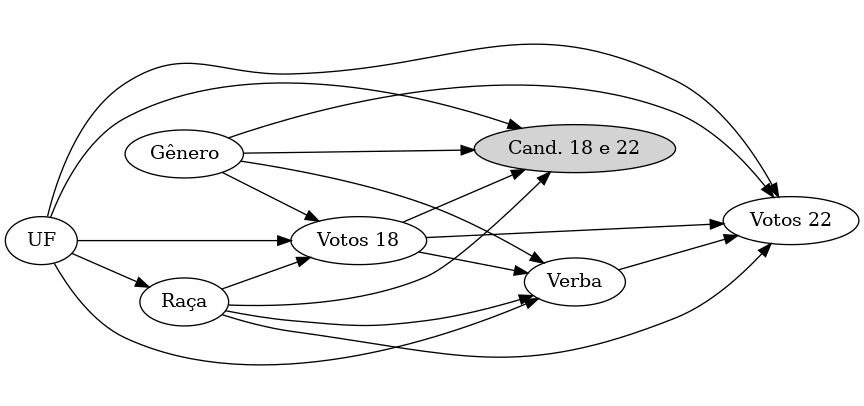

In [11]:
# Grafo completo:
edges = [('Raça', 'Votos 22'), ('Gênero', 'Votos 22'), ('UF', 'Votos 22'), ('Votos 18', 'Votos 22'),
         ('Raça', 'Votos 18'), ('Gênero', 'Votos 18'), ('UF', 'Votos 18'),    ('Verba', 'Votos 22'),
         ('Raça', 'Verba'),    ('Gênero', 'Verba'),    ('UF', 'Verba'),    ('Votos 18', 'Verba'),
         ('Raça', 'Cand. 18 e 22'), ('Gênero', 'Cand. 18 e 22'), ('UF', 'Cand. 18 e 22'), ('Votos 18', 'Cand. 18 e 22'),
         ('UF', 'Raça')]

xc.plot_diagram(edges, special_nodes={'target':'Cand. 18 e 22'})

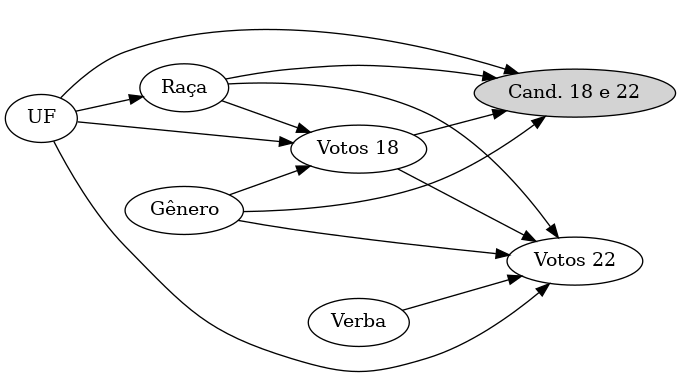

In [12]:
# Grafo com intervenção em "Verba":
edges = [('Raça', 'Votos 22'), ('Gênero', 'Votos 22'), ('UF', 'Votos 22'), ('Votos 18', 'Votos 22'),
         ('Raça', 'Votos 18'), ('Gênero', 'Votos 18'), ('UF', 'Votos 18'),    ('Verba', 'Votos 22'),
         #('Raça', 'Verba'),    ('Gênero', 'Verba'),    ('UF', 'Verba'),    ('Votos 18', 'Verba'),
         ('Raça', 'Cand. 18 e 22'), ('Gênero', 'Cand. 18 e 22'), ('UF', 'Cand. 18 e 22'), ('Votos 18', 'Cand. 18 e 22'),
         ('UF', 'Raça')]

xc.plot_diagram(edges, special_nodes={'target':'Cand. 18 e 22'})

## Análises preliminares

### Independência entre UF e gênero/raça

Pelo nosso grafo causal, a única relação entre essas variáveis se dá devido à seleção de candidatos que concorreram nas duas eleições.

In [13]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from collections import defaultdict

import brass as br

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [14]:
# Seleciona dados:
sel_df = full_df
print('# candidaturas:', len(sel_df))

# Agrupando UFs em regiões:
ufs = ['AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'SP', 'TO']
reg = ['N',  'NE', 'N',  'N',  'NE', 'NE', 'SE', 'CO', 'NE', 'SE', 'CO', 'CO', 'N',  'NE', 'NE', 'NE', 'S',  'SE', 'NE', 'N',  'N',  'S',  'S',  'NE', 'SE', 'CO']

# Cria mapas para categorias:
reg_encoder = dict(zip(ufs, reg))
raca_encoder = defaultdict(lambda: 0, {'BRANCA': 1})
gen_encoder = {'MASCULINO': 1, 'FEMININO': 0}

# Mapeia categorias:
dsep_df = pd.DataFrame()
dsep_df['branca'] = sel_df['DS_COR_RACA'].map(raca_encoder)
dsep_df['masc'] = sel_df['DS_GENERO'].map(gen_encoder)
dsep_df['regiao'] = sel_df['SG_UF'].map(reg_encoder)

passcols = ['masc', 'branca']
regcols  = ['regiao']
trafo    = ColumnTransformer([('reg', OneHotEncoder(), regcols), ('cand', 'passthrough', passcols)])
X = trafo.fit_transform(dsep_df)
dsep_df = pd.DataFrame(data=X, columns=trafo.get_feature_names_out(), dtype=int)

# candidaturas: 2975


Vamos verificar se a região do país está associada a raça ou gênero. Se não estiver, ela pode estar d-separada.

In [19]:
assocs = []
for reg in ['reg__regiao_CO', 'reg__regiao_N', 'reg__regiao_NE', 'reg__regiao_S', 'reg__regiao_SE']:
    for cand in ['cand__masc', 'cand__branca']:
        test_df = dsep_df.loc[:, [reg, cand]]
        assoc = br.AssocEstimator(onehot_trials=test_df)
        chain_df = assoc.sample_model()        
        assocs.append(assoc.summarize_stats(chain_df, reg, cand))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


A tabela abaixo mostra estimativas da probabilidade marginal e condicional de se observar uma categoria de UF dado outra (de raça ou gênero). Também vemos o valor p para a hipótese da diferença entre as duas probabilidades ser compatível com zero. 

In [20]:
assoc_df = pd.concat(assocs, ignore_index=True)
assoc_df.sort_values('delta p-value')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),"deltaP(A,B)","dev deltaP(A,B)",abs delta nsigma,delta p-value
19,B,cand__branca,reg__regiao_SE,0.560893,0.009040,0.614516,0.015070,0.053623,0.012398,4.325227,0.0000
17,B,cand__masc,reg__regiao_SE,0.761369,0.007696,0.716009,0.013896,-0.045360,0.010976,4.132493,0.0000
16,F,reg__regiao_SE,cand__masc,0.344208,0.008554,0.323701,0.009690,-0.020506,0.004984,4.114622,0.0000
15,B,cand__branca,reg__regiao_S,0.560859,0.009190,0.882064,0.016054,0.321205,0.016384,19.604471,0.0000
14,F,reg__regiao_S,cand__branca,0.140099,0.006297,0.220331,0.010001,0.080232,0.005256,15.265362,0.0000
11,B,cand__branca,reg__regiao_NE,0.560941,0.009110,0.478240,0.018403,-0.082701,0.015852,5.217215,0.0000
6,F,reg__regiao_N,cand__branca,0.166558,0.006779,0.092120,0.007127,-0.074438,0.006237,11.934400,0.0000
7,B,cand__branca,reg__regiao_N,0.560793,0.009112,0.310137,0.020607,-0.250657,0.019132,13.101577,0.0000
10,F,reg__regiao_NE,cand__branca,0.246593,0.007845,0.210236,0.009890,-0.036358,0.007055,5.153265,0.0000
18,F,reg__regiao_SE,cand__branca,0.344202,0.008666,0.377111,0.011845,0.032909,0.007644,4.304935,0.0000


### Independência entre raça e gênero

Vamos testar se Raça e Gênero estão d-separados sem qualquer condicionamento. Se estiver, eles só podem estar conectados por um caminho que inclui um colisor.

In [15]:
assoc = br.AssocEstimator(onehot_trials=dsep_df[['cand__branca', 'cand__masc']])

In [16]:
chain_df = assoc.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


O gráfico da direita mostra a distribuição de probabilidade a posteriori para a diferença $P(\mathrm{Cor = Branca}|\mathrm{Gênero = Masculino}) - P(\mathrm{Cor = Branca})$

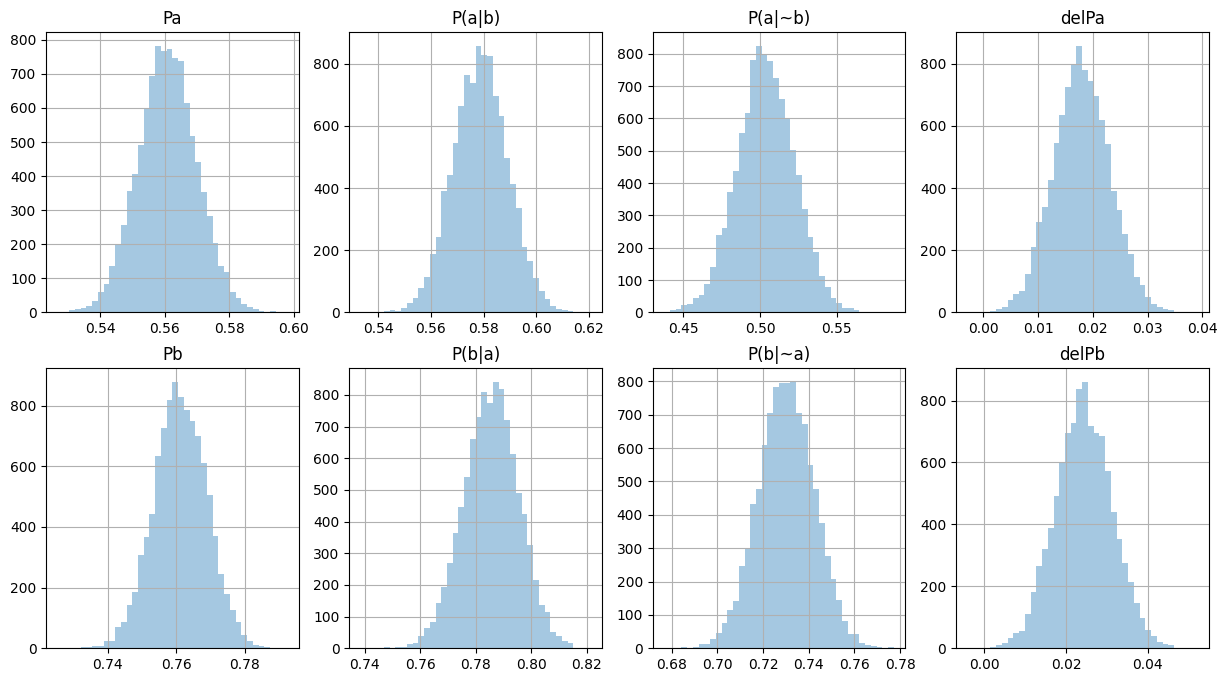

In [17]:
assoc.plot_chain_probs(chain_df)

In [18]:
assoc.summarize_stats(chain_df, 'Branca', 'Masculino')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),"deltaP(A,B)","dev deltaP(A,B)",abs delta nsigma,delta p-value
0,F,Branca,Masculino,0.560872,0.009081,0.578797,0.010362,0.017925,0.005138,3.488690,0.0002
1,B,Masculino,Branca,0.761247,0.007762,0.785575,0.009941,0.024328,0.006966,3.492565,0.0002


Resultado acima indica que raça e gênero não são d-separados na amostra. Deduzimos que isso é causado por um efeito de seleção: 
condicionamos os dados no colisor que é o fato da pessoa se candidatar, e gênero e raça importam para isso. Mas o efeito é pequeno. Talvez possamos ignorar.

### Gráficos das correlações

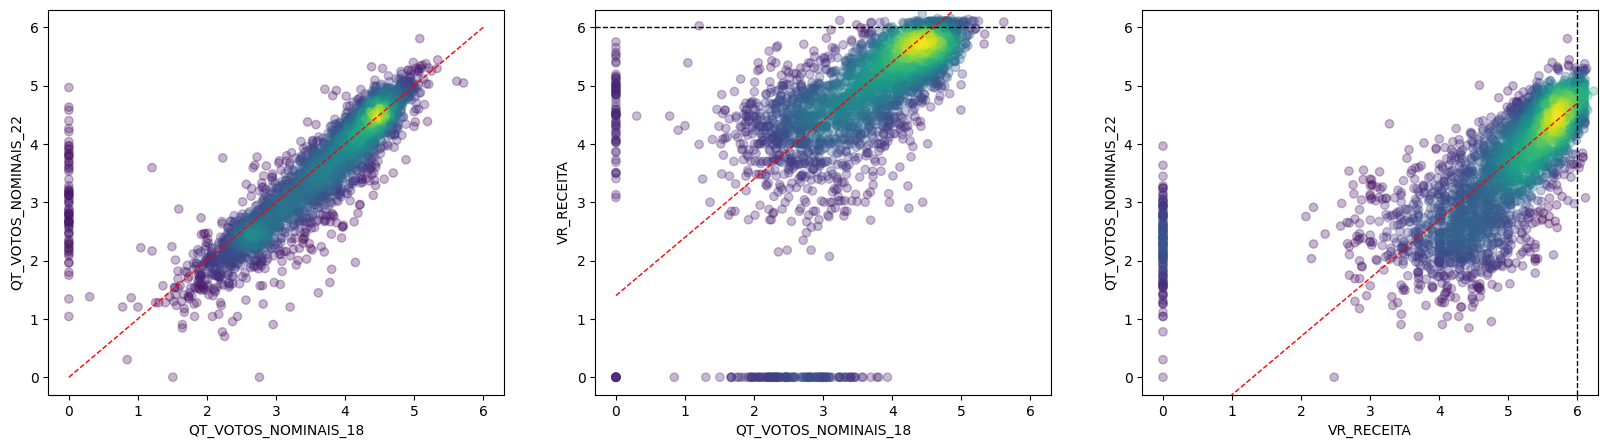

In [19]:
vars = ['QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA']
pl.figure(figsize=(20, 5))

xdiag = np.linspace(0,6, 10)

pl.subplot(1,3,1)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + full_df[x]), np.log10(1 + full_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.plot(xdiag, xdiag, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,2)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'VR_RECEITA'
xp.density_scatter_plot(np.log10(1 + full_df[x]), np.log10(1 + full_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axhline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag + 1.4, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,3)
x = 'VR_RECEITA'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + full_df[x]), np.log10(1 + full_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axvline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag - 1.3, color='r', linestyle='--', linewidth=1)

pl.show()

O gráfico acima mostra a relação para $\log_{10}(1+x)$, onde $x$ é a variável mencionada nos eixos do gráfico.

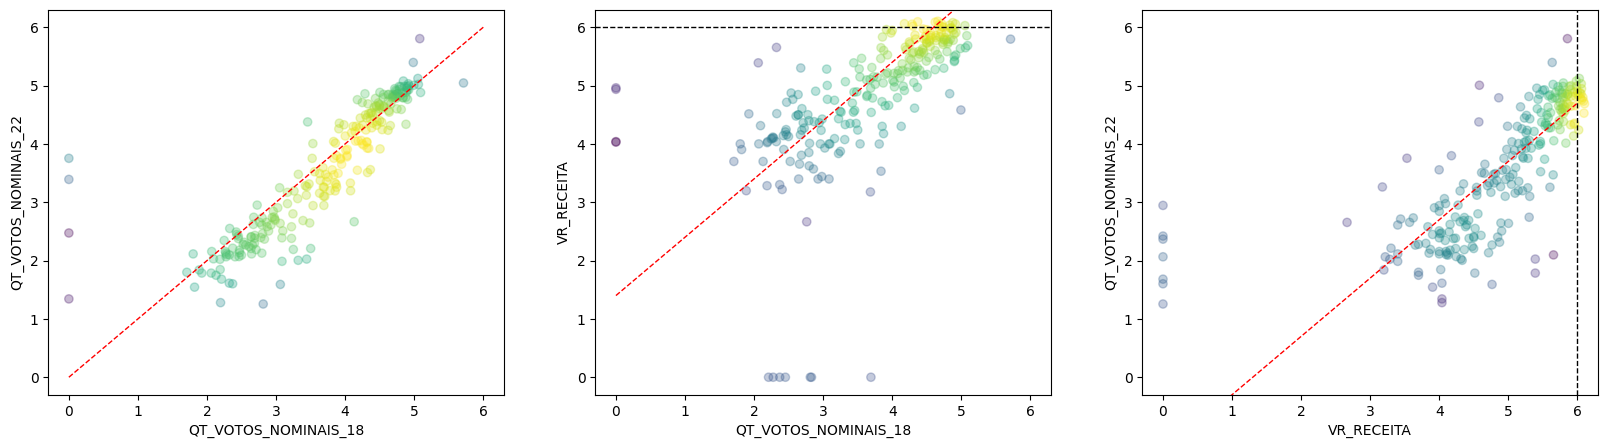

In [20]:
# Para UFs específicas:

vars = ['QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA']
slice_df = full_df.query('SG_UF == "MG"')
#slice_df = full_df.query('DS_GENERO == "FEMININO"')
#slice_df = full_df.query('DS_COR_RACA != "BRANCA"')

pl.figure(figsize=(20, 5))

xdiag = np.linspace(0,6, 10)

pl.subplot(1,3,1)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + slice_df[x]), np.log10(1 + slice_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.plot(xdiag, xdiag, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,2)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'VR_RECEITA'
xp.density_scatter_plot(np.log10(1 + slice_df[x]), np.log10(1 + slice_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axhline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag + 1.4, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,3)
x = 'VR_RECEITA'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + slice_df[x]), np.log10(1 + slice_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axvline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag - 1.3, color='r', linestyle='--', linewidth=1)

pl.show()

## Limpeza dos dados

Pessoas com zero votos são tipicamente (embora minha experiência prévia com outros estudos aponte para isso, não verificamos isso novamente nos dados deste estudo):

1. Candidaturas laranjas feitas para burlar a cota de gênero, e não estão realmente buscando votos; ou
2. Pessoas que tiveram problemas judiciais com a candidatura e não tiveram votos registrados.

Por isso, vamos ignorar esses casos. Em relação às receitas, é estranho uma campanha não gastar absolutamente nada. 
Isso é mais plausível se entendermos esses casos como candidaturas que não realizaram a prestação de contas. 
Logo, esses dados não representam a realidade dos gastos tal qual os demais (apesar da existência de caixa dois nos outros casos, 
provavelmente especialmente naqueles no teto do limite de gastos). Assim, vamos ignorar esses dados com zero receitas, também.

In [21]:
# Limpando os dados:
clean_df = full_df.query('VR_RECEITA > 0 & QT_VOTOS_NOMINAIS_18 > 0 & QT_VOTOS_NOMINAIS_22 > 0')

Outra vantagem dessa limpeza é que podemos aplicar o log sem problemas.

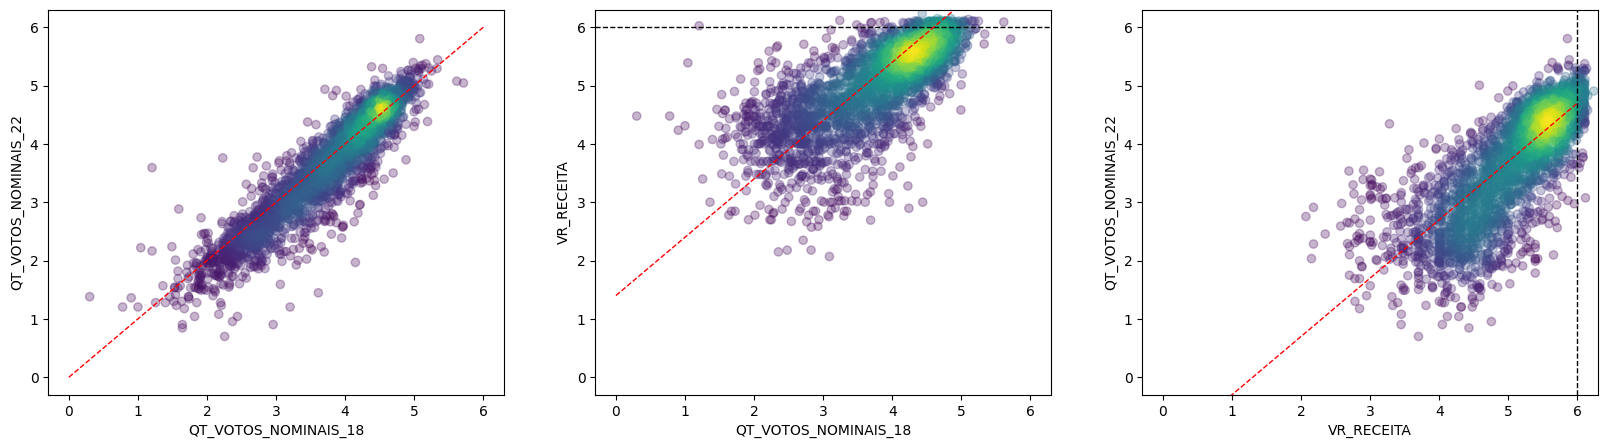

In [22]:
# Visualização:
vars = ['QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA']
pl.figure(figsize=(20, 5))

xdiag = np.linspace(0,6, 10)

pl.subplot(1,3,1)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + clean_df[x]), np.log10(1 + clean_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.plot(xdiag, xdiag, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,2)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'VR_RECEITA'
xp.density_scatter_plot(np.log10(1 + clean_df[x]), np.log10(1 + clean_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axhline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag + 1.4, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,3)
x = 'VR_RECEITA'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + clean_df[x]), np.log10(1 + clean_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axvline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag - 1.3, color='r', linestyle='--', linewidth=1)

pl.show()

#### Exprorando os dados

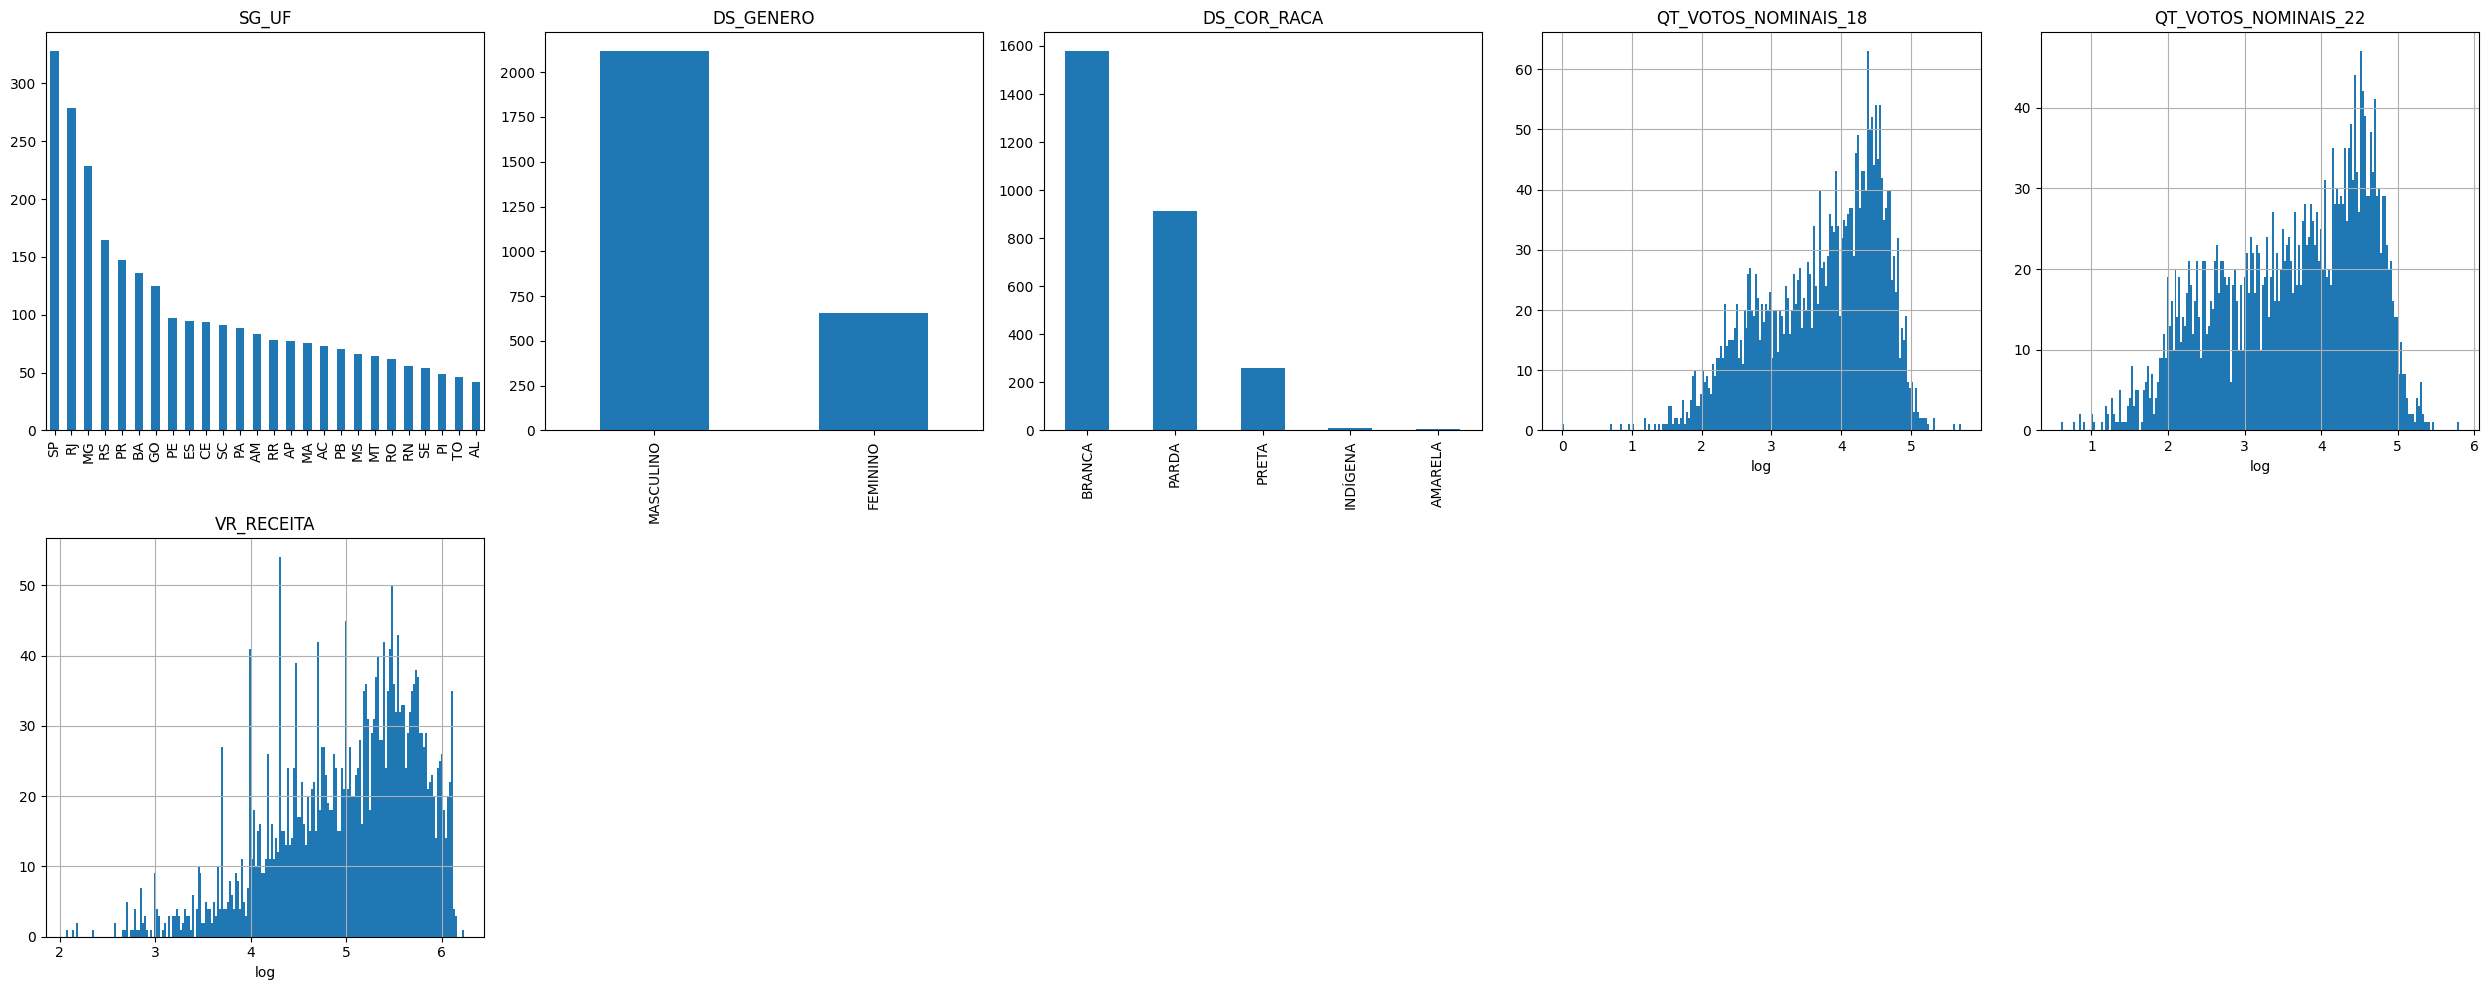

In [23]:
xe.multiple_dist_plots(clean_df[['SG_UF', 'DS_GENERO', 'DS_COR_RACA', 'QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA']])

## Ajuste ingênuo

Vamos ver que tipo de relação entre verba (receita) e número de votos seria deduzida se ajustássemos um modelo univariado para prever os votos a partir da verba, sem controlar os confusores. 

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import xavy.mltools as ml

/home/hxavier/system/envs/mcmc/lib/python3.8/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


O modelo abaixo trabalha com o log das variáveis independentes. 
No final, vamos modelar o log do número de votos a partir do log da receita, utilizando uma relação linear entre os logs. Ou seja: vamos modelar a relação entre receita e votos como uma lei de potência.

In [25]:
# Construção do modelo:
model = Pipeline([('log', ml.LogPlus()), ('fit', LinearRegression())])
lm = model['fit']

In [26]:
# Ajuste do modelo:
dump = model.fit(clean_df[['VR_RECEITA']] / 10**5, np.log10(clean_df['QT_VOTOS_NOMINAIS_22']))

In [27]:
# Fator de escala:
10**lm.intercept_

4181.679973023466

In [28]:
# Expoente:
lm.coef_[0]

0.970871482370228

O coeficiente acima mostra uma relação aproximadamente linear. Ou seja: em média, a quantidade de votos ganhos aumenta na mesma quantidade quando aportamos uma determinada quantidade de receita para a candidatura, independentemente de quanta receita ela já tem. 


#### Estimativa da variância

In [29]:
def one_boostrap_fit_loglinear(model, df, X_cols, y_col, scale_n_zeros=5):
    
    # Get sample:
    bootstrap_df = df.sample(len(df), replace=True)
    # Get features:
    X = bootstrap_df[X_cols] / 10**scale_n_zeros
    # Transform target:
    y = np.log10(bootstrap_df[y_col])
    
    # Ajuste do modelo:
    dump = model.fit(X, y)
    
    # Fator de escala:
    a = 10**(model['fit'].intercept_)
    # Expoente:
    b = lm.coef_[0]
    
    return {'scale': a, 'exponent': b}

In [30]:
# Vamos coletar os parâmetros da lei de potência para ajustes feitos sobre amostras sorteadas com reposição:
n_samples = 10000
samples = [one_boostrap_fit_loglinear(model, clean_df, ['VR_RECEITA'], 'QT_VOTOS_NOMINAIS_22') for _ in range(n_samples)]
samples_df = pd.DataFrame(samples)

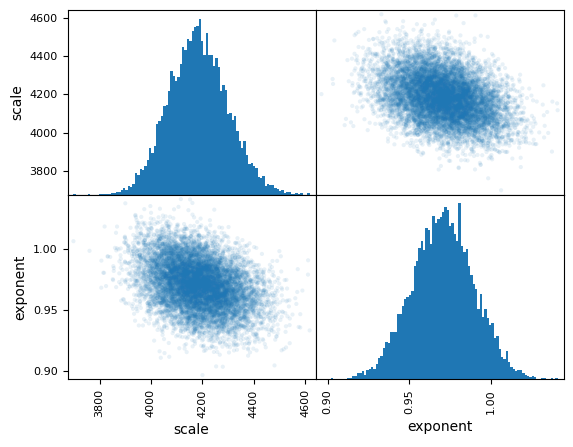

In [31]:
# Distribuição dos parâmetros:
pd.plotting.scatter_matrix(samples_df, alpha=0.1, hist_kwds={'bins': 100})
pl.show()

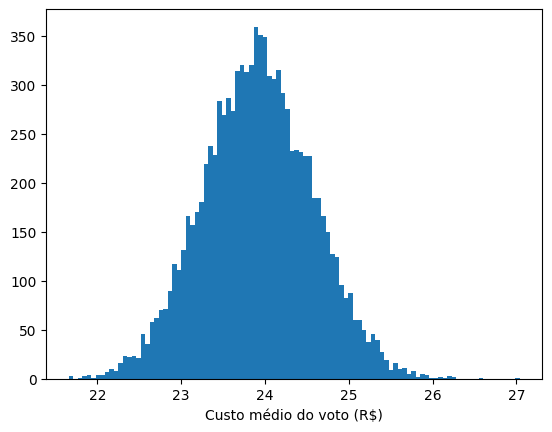

In [32]:
# Aproximando a relação como linear, qual é o custo do voto?
pl.hist(10**5 / samples_df['scale'], bins=100)
pl.xlabel('Custo médio do voto (R\\$)')
pl.show()

#### Comparação com os dados

Vamos comparar os dados com a lei de potência ajustada:

In [33]:
def naive_prediction(scale, exponent, receita, scale_n_zeros=5):
    return scale * (receita / 10**scale_n_zeros) ** exponent

/home/hxavier/system/envs/mcmc/lib/python3.8/site-packages/scipy/interpolate/_fitpack2.py:1324: UserWarning: ier=696
  warnings.warn(message)


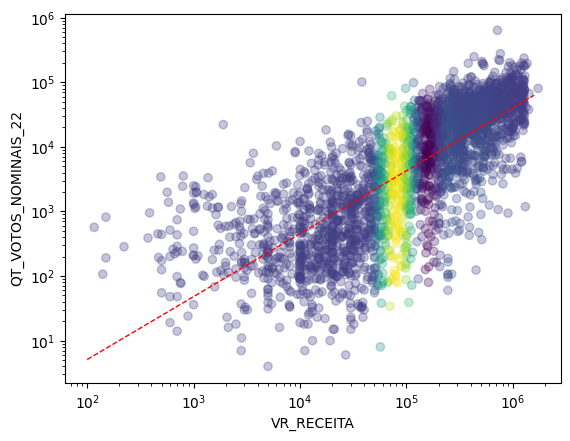

In [34]:
x = 'VR_RECEITA'
y = 'QT_VOTOS_NOMINAIS_22'

r = np.logspace(2, 6.2, 100)
y_pred = naive_prediction(10**lm.intercept_, lm.coef_[0], r)

xp.density_scatter_plot(clean_df[x], clean_df[y], alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.plot(r, y_pred, color='r', linestyle='--', linewidth=1)
pl.yscale('log')
pl.xscale('log')
pl.show()

## Simulação (geração de dados sintéticos)

Vamos criar dados sintéticos que obedecem ao grafo proposto e apresenta distribuições marginais semelhantes a de dados reais. Esses dados sintéticos serão utilizados para testar nossos métodos de inferência causal.

In [35]:
# Generate sources:
# UF:
n_ufs = 26
uf_probs = np.linspace(1, 1.3, n_ufs) + np.linspace(1, 10, n_ufs) ** 6 / 1e5
uf_probs = uf_probs / uf_probs.sum()
uf = xc.generate_source(type='categorical', cat_probs=uf_probs)
# Gênero:
genero = xc.generate_source(type='categorical')

# Generate dependent variables:

# Raça:
p_branca = np.random.random(size=n_ufs)
p_parda  = (1 - p_branca) * np.random.random(size=n_ufs)
p_preta  = 1 - p_branca - p_parda
p_raca = np.take(np.transpose([p_branca, p_parda, p_preta]), uf, axis=0)
raca = np.array([np.random.choice([0, 1, 2], size=None, p=p_raca[i]) for i in range(len(p_raca))], dtype=int)

# Votos em 2018:
pop0_18 = np.random.beta(0.5, 60, len(uf)) # Popularidade basal do candidato (prob. de receber voto).
pop_18  = pop0_18 * (1 + genero * 0.05) * (1 - raca * 0.04) # Popularidade ajustada pelo gênero (1=homem) e raça (0=branca, 1=parda, 2=preta).
voters_per_uf_18 = (uf_probs * 6e7).astype(int) # Núm. eleitores em cada estado.
n_voters_18 = np.take(voters_per_uf_18, uf) # Núm. de eleitores para cada candidato.
votos18 = np.random.binomial(n_voters_18, pop_18).clip(min=1) # Núm. de votos.

# Se candidatou em 2018 e 2022:
p0_cand  = np.random.random(len(uf)) * 0.3 # Prob. basal do candidato concorrer de novo.
p_cand   = ((p0_cand + (votos18 / n_voters_18)**0.5 * 3) * (1 - (1 - genero) * 0.7) * (1 - raca ** 2 * 0.05)).clip(0.0, 0.98) # Prob. final do candidato concorrer de novo.
cand1822 = (np.random.random(len(uf)) < p_cand).astype(int)

# Receita:
mean_receita = 24 * votos18 / ((n_voters_18 / 1e6) ** 0.2) * (1 + genero * 0.2) * (1 - raca ** 0.5 * 0.05) # Valor esperado.
receita_livre = np.random.normal(mean_receita, mean_receita * 0.55).clip(1) # Receita se não houvesse limite de gastos.
fake_receita = np.abs(np.random.normal(5e5, 4e5, len(receita_livre))) # Valor declarado caso passe do limite.
receita = np.where(receita_livre > 1.4e6, fake_receita, receita_livre) # Receita final (com limite).

# Votos em 2022:
def mean_verba_effect(verba):
    return 0.10 + 0.90 * (verba / 1e5) ** 0.3
    #return 0.10 + 0.90 * (verba / 1e5) ** 1.3
    #return 1
    #return verba / receita.mean()
    #return (receita.max() - verba) / receita.mean()
var_votos = np.exp(np.random.standard_t(20, len(uf)) / 2) - 1 # Fractional variation of votes
votos22   = (votos18 * (1 + var_votos) * mean_verba_effect(receita) / ((n_voters_18 / 1e6) ** 0.2) * (1 + genero * 0.2) * (1 - raca ** 0.5 * 0.05)).clip(1) # Votos em 2022.

# Efeito de seleção:
mock_df = pd.DataFrame(data=np.transpose([uf, genero, raca, votos18, votos22, receita, cand1822, var_votos, n_voters_18]), 
                       columns=['SG_UF', 'DS_GENERO', 'DS_COR_RACA', 'QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA', 'CANDIDATOU', 'VAR_VOTOS', 'N_VOTERS_18'])
mock_df['SG_UF'] = mock_df['SG_UF'].astype(int)
mock_df['DS_GENERO'] = mock_df['DS_GENERO'].astype(int)
mock_df['DS_COR_RACA'] = mock_df['DS_COR_RACA'].astype(int)
mock_df['QT_VOTOS_NOMINAIS_18'] = mock_df['QT_VOTOS_NOMINAIS_18'].astype(int)
mock_df['QT_VOTOS_NOMINAIS_22'] = mock_df['QT_VOTOS_NOMINAIS_22'].astype(int)
mock_df['CANDIDATOU'] = mock_df['CANDIDATOU'].astype(int)
mock_df['N_VOTERS_18'] = mock_df['N_VOTERS_18'].astype(int)
mock_selected_df = mock_df.query('CANDIDATOU == 1')

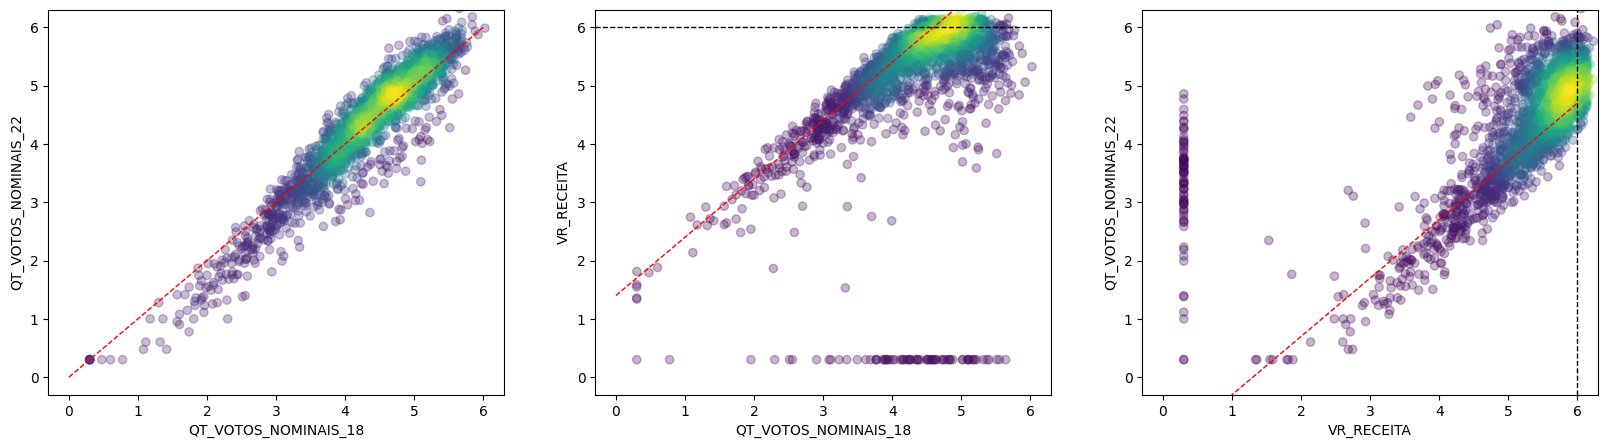

In [36]:
# Gráficos da correlação entre algumas variáveis de interesse:

vars = ['QT_VOTOS_NOMINAIS_18', 'QT_VOTOS_NOMINAIS_22', 'VR_RECEITA']
pl.figure(figsize=(20, 5))

xdiag = np.linspace(0,6, 10)

pl.subplot(1,3,1)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + mock_selected_df[x]), np.log10(1 + mock_selected_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.plot(xdiag, xdiag, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,2)
x = 'QT_VOTOS_NOMINAIS_18'
y = 'VR_RECEITA'
xp.density_scatter_plot(np.log10(1 + mock_selected_df[x]), np.log10(1 + mock_selected_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axhline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag + 1.4, color='r', linestyle='--', linewidth=1)

pl.subplot(1,3,3)
x = 'VR_RECEITA'
y = 'QT_VOTOS_NOMINAIS_22'
xp.density_scatter_plot(np.log10(1 + mock_selected_df[x]), np.log10(1 + mock_selected_df[y]), alpha=0.3)
pl.xlabel(x); pl.ylabel(y)
pl.xlim([-0.3, 6.3]); pl.ylim([-0.3, 6.3])
pl.axvline(6, color='k', linewidth=1, linestyle='--')
pl.plot(xdiag, xdiag - 1.3, color='r', linestyle='--', linewidth=1)

pl.show()

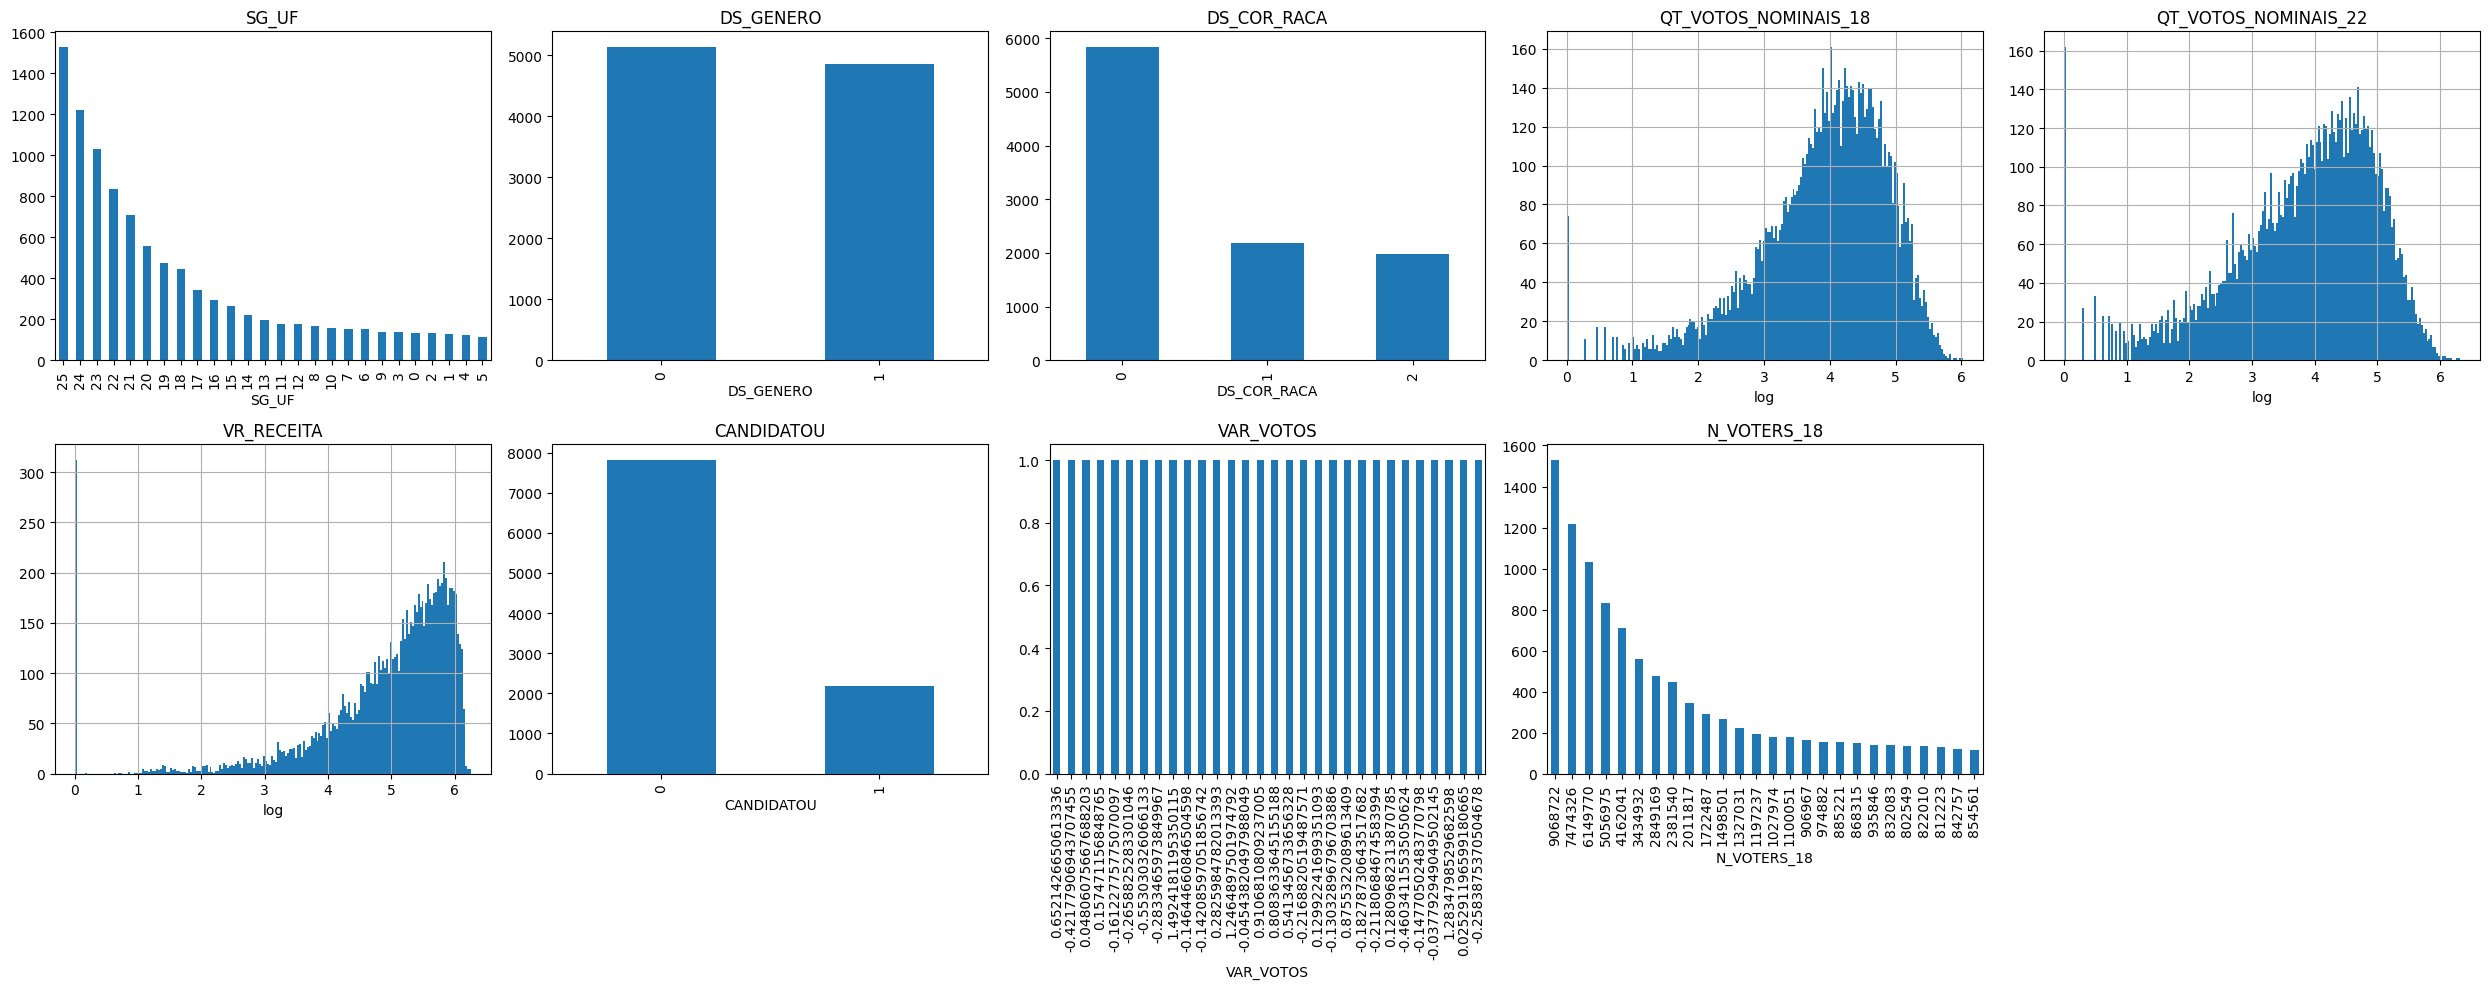

In [37]:
# Dados simulados sem efeito de seleção:
xe.multiple_dist_plots(mock_df)

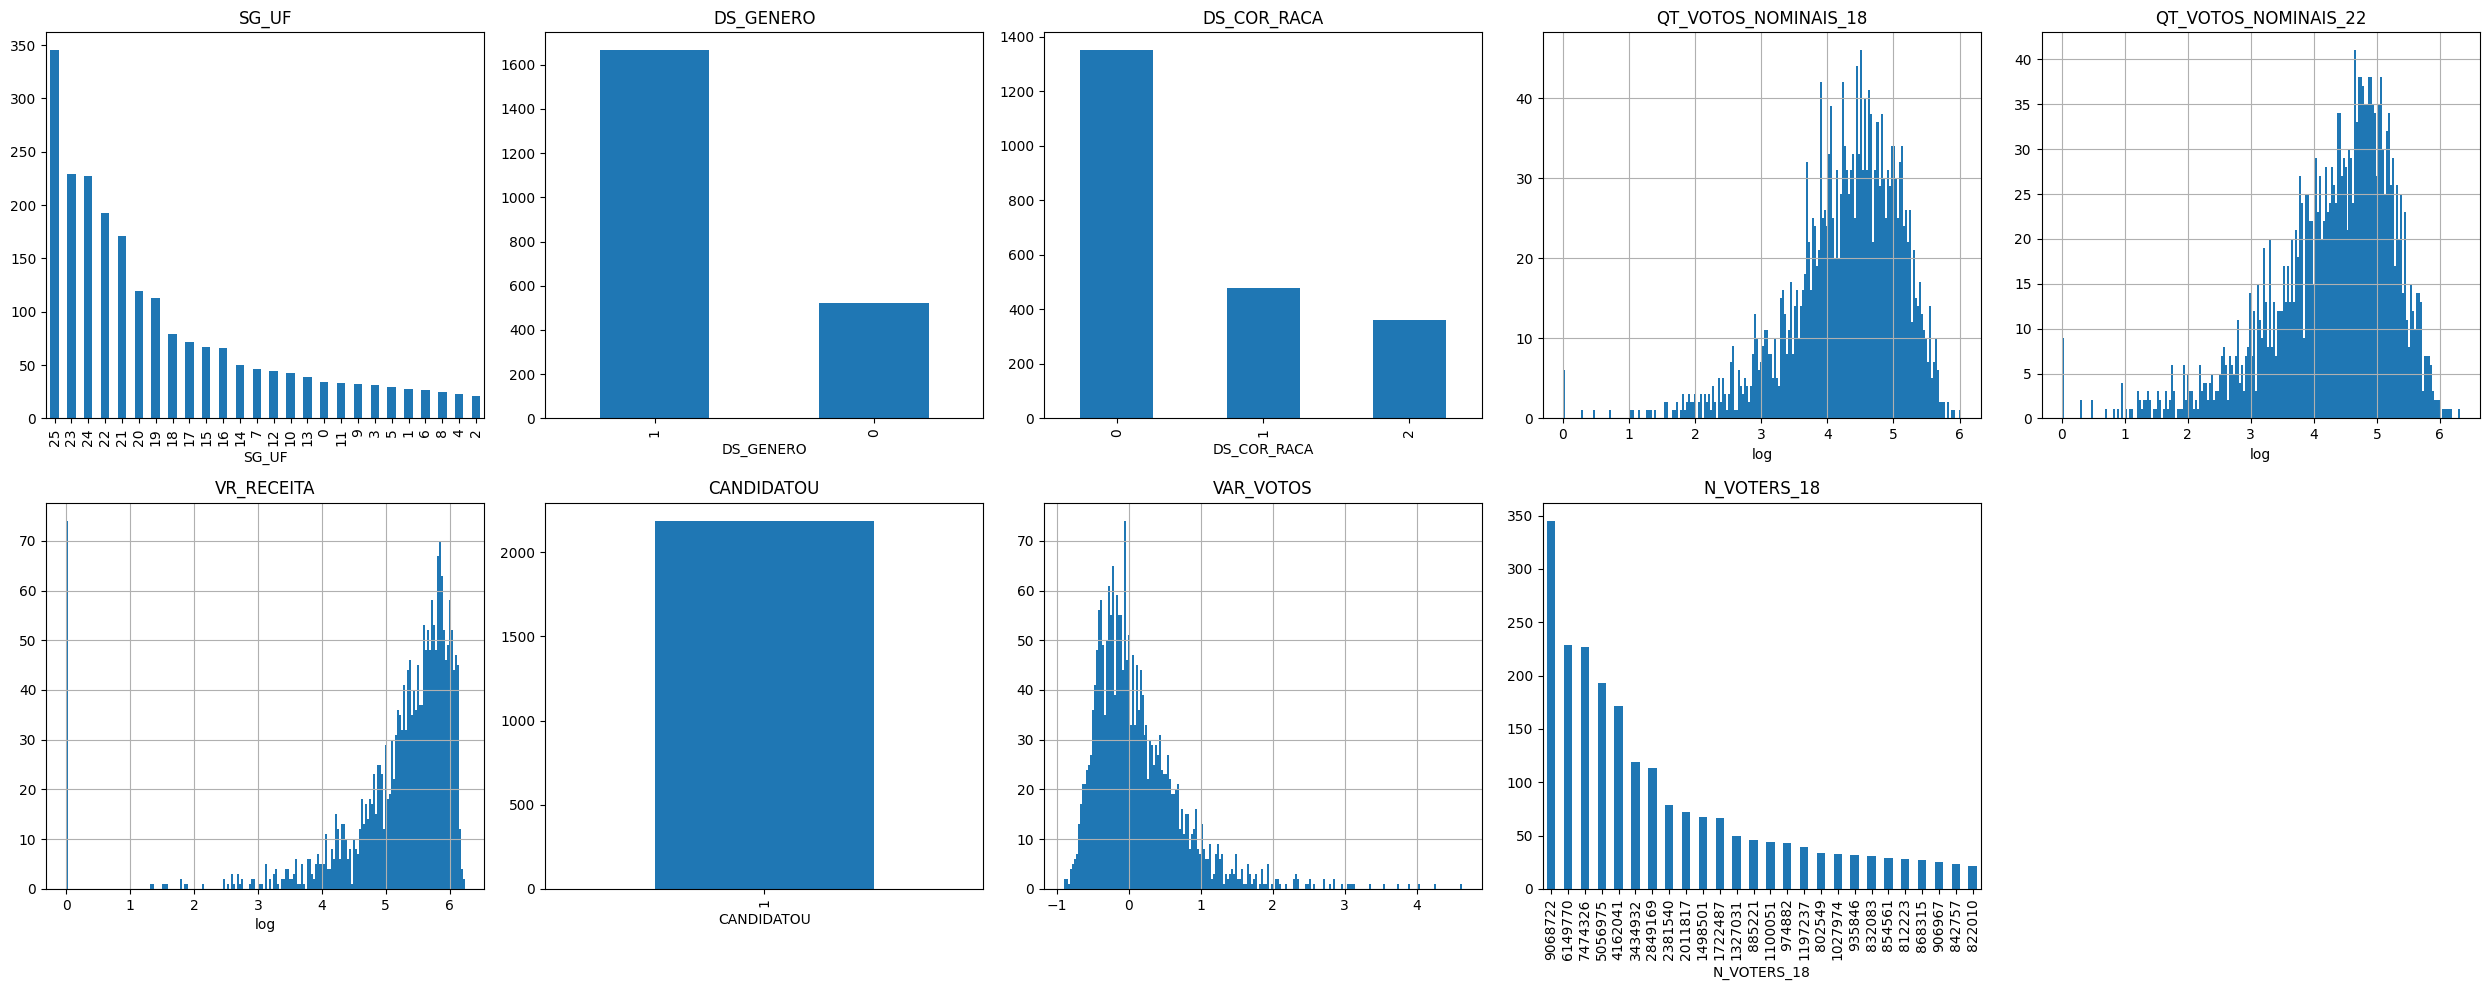

In [38]:
# Dados simulados finais (com efeito de seleção):
xe.multiple_dist_plots(mock_selected_df)

## Ajuste sobre os dados sintéticos

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import KFold

import xavy.mltools as ml

Vamos aplicar nosso código de estimação de efeito causal através da fórmula do ajuste sobre os dados simulados. Daí, vamos comparar a relação estimada com a real (i.e. utilizada para simular os dados):

### Preparação dos dados sintéticos

In [40]:
# Prepare data:
mock_X_df     = mock_selected_df[['SG_UF', 'DS_GENERO', 'DS_COR_RACA', 'QT_VOTOS_NOMINAIS_18', 'VR_RECEITA']].copy()
mock_y_series = np.log10(mock_selected_df['QT_VOTOS_NOMINAIS_22'])
#mock_X_df     = mock_df[['SG_UF', 'DS_GENERO', 'DS_COR_RACA', 'QT_VOTOS_NOMINAIS_18', 'VR_RECEITA']].copy()
#mock_y_series = np.log10(mock_df['QT_VOTOS_NOMINAIS_22'])
mock_Xy_df = mock_X_df.copy()
mock_Xy_df['log_QT_VOTOS_NOMINAIS_22'] = mock_y_series

### Criação do modelo

In [41]:
#### Create transformers:
mock_raca_trafo = Pipeline([('agg', 'passthrough'), ('enc', OneHotEncoder(categories=[[0, 1, 2]], drop='first'))])
mock_ufs_list   = [i for i in range(26)]
mock_cat_trafo  = OneHotEncoder(categories=[mock_ufs_list, [0, 1]], drop='first')
mock_num_trafo  = Pipeline([('log', ml.LogPlus()), ('cen', StandardScaler(with_std=True))])
mock_trafo      = ColumnTransformer([('raca', mock_raca_trafo, ['DS_COR_RACA']), ('cat', mock_cat_trafo, ['SG_UF', 'DS_GENERO']), ('num', mock_num_trafo, ['QT_VOTOS_NOMINAIS_18', 'VR_RECEITA'])])
# Fitter:
#fitter     = Ridge(alpha=30)
#mock_fitter     = RandomForestRegressor(max_depth=9, min_samples_split=60)
mock_fitter     = SVR(C=1, gamma=0.1)
# Ful pipeline:
mock_model = Pipeline([('trafo', mock_trafo), ('fit', mock_fitter)])

### Estimativa do efeito causal

Para estimar o efeito causal, vamos utilizar k-folds para ajustar o modelo a parte dos dados e realizar a estimativa na outra parte. Visamos evitar qualquer tipo de overfitting.

In [42]:
do_var = 'VR_RECEITA'
do_values = np.logspace(1, 6.3, 50)

# Initialize KFold with 5 splits:
kf = KFold(n_splits=5, shuffle=True, random_state=421)

# Loop over data splits:
y_preds = []
for train_index, test_index in kf.split(mock_X_df):
    print('Test set size: ', len(test_index)) # sets must have approx. the same size.
    # Train model:
    X_train, y_train = mock_X_df.iloc[train_index], mock_y_series.iloc[train_index]
    mock_model.fit(X_train, y_train)
    # Predict:
    X_test = mock_X_df.iloc[test_index]
    y_pred = adjustment_predict_intervention(mock_model, X_test, do_var, do_values)
    y_preds.append(y_pred)

y_pred_series = pd.concat(y_preds)
y_pred_final  = y_pred_series.groupby(y_pred_series.index).mean()

Test set size:  438
Test set size:  437
Test set size:  437
Test set size:  437
Test set size:  437


### Comparação da estimativa com o real (função utilizada para gerar os dados)

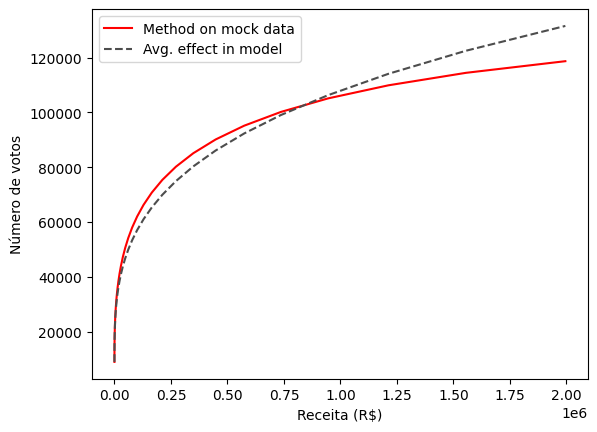

In [43]:
# Compute expected avg. causal effect on mock data:
#y_mean = np.array([(votos18 * (1 + var_votos) * mean_verba_effect(r) / ((n_voters_18 / 1e6) ** 0.2) * (1 + genero * 0.2) * (1 - raca ** 0.5 * 0.05)).clip(1).mean() for r in do_values])
y_mean = np.array([(mock_selected_df['QT_VOTOS_NOMINAIS_18'] * (1 + mock_selected_df['VAR_VOTOS']) * mean_verba_effect(r) / ((mock_selected_df['N_VOTERS_18'] / 1e6) ** 0.2) * (1 + mock_selected_df['DS_GENERO'] * 0.2) * (1 - mock_selected_df['DS_COR_RACA'] ** 0.5 * 0.05)).clip(1).mean() for r in do_values])
#y_mean = np.array([(mock_df['QT_VOTOS_NOMINAIS_18'] * (1 + mock_df['VAR_VOTOS']) * mean_verba_effect(r) / ((mock_df['N_VOTERS_18'] / 1e6) ** 0.2) * (1 + mock_df['DS_GENERO'] * 0.2) * (1 - mock_df['DS_COR_RACA'] ** 0.5 * 0.05)).clip(1).mean() for r in do_values])

# Plot model prediction:
pl.plot(y_pred_final.index, 10**y_pred_final.values * 3.4, color='r', label='Method on mock data')
# Plot expected value:
pl.plot(do_values, y_mean, color='0.3', linestyle='--', label='Avg. effect in model')
pl.legend()

pl.xlabel('Receita (R$)')
pl.ylabel('Número de votos')
#pl.yscale('log')
#pl.xscale('log')
pl.show()

## Ajuste sobre os dados reais

Vamos usar a fórmula do ajuste para medir o efeito causal da receita sobre a quantidade de votos. Para tanto, vamos assumir que nosso modelo causal descreve corretamente o processo gerador dos dados observados.

### Preparando os dados

In [44]:
# Função para juntar raças:
def agg_raca(raca):
    mapper = {'BRANCA': 'BRANCA-AMARELA',
              'PARDA': 'PARDA-INDIGENA',
              'PRETA': 'PRETA',
              'INDÍGENA': 'PARDA-INDIGENA',
              'AMARELA': 'BRANCA-AMARELA'}
    vec_mapper = np.vectorize(lambda x: mapper[x])
    return vec_mapper(raca)

In [45]:
# Prepare data:
X_df     = clean_df[['SG_UF', 'DS_GENERO', 'DS_COR_RACA', 'QT_VOTOS_NOMINAIS_18', 'VR_RECEITA']].copy()
y_series = np.log10(clean_df['QT_VOTOS_NOMINAIS_22'])
Xy_df = X_df.copy()
Xy_df['log_QT_VOTOS_NOMINAIS_22'] = y_series

### Construção do modelo

Vamos construir um modelo qualquer (i.e. não necessariamente linear ou de lei de potência) para ajustar sobre os dados:

In [47]:
#### Create transformers:
raca_trafo = Pipeline([('agg', FunctionTransformer(agg_raca)), ('enc', OneHotEncoder(categories=[['BRANCA-AMARELA', 'PARDA-INDIGENA', 'PRETA']], drop='first'))])
ufs_list   = ['SP', 'AC', 'AL', 'AM', 'AP', 'BA', 'CE', 'ES', 'GO', 'MA', 'MG', 'MS', 'MT', 'PA', 'PB', 'PE', 'PI', 'PR', 'RJ', 'RN', 'RO', 'RR', 'RS', 'SC', 'SE', 'TO']
cat_trafo  = OneHotEncoder(categories=[ufs_list, ['MASCULINO', 'FEMININO']], drop='first')
num_trafo  = Pipeline([('log', ml.LogPlus()), ('cen', StandardScaler(with_std=True))])
trafo      = ColumnTransformer([('raca', raca_trafo, ['DS_COR_RACA']), ('cat', cat_trafo, ['SG_UF', 'DS_GENERO']), ('num', num_trafo, ['QT_VOTOS_NOMINAIS_18', 'VR_RECEITA'])])
# Fitter:
#fitter     = Ridge(alpha=30)
#fitter     = RandomForestRegressor(max_depth=9, min_samples_split=60) # max_depth=9, min_samples_split=60
fitter     = SVR(C=1, gamma=0.1)
# Ful pipeline:
model = Pipeline([('trafo', trafo), ('fit', fitter)])

### Ajuste fino dos hiperparâmetros

Fine-tuning dos parâmetros:

In [50]:
param_grid = {#'fit__alpha': [0.1, 0.3, 1, 2, 3, 6, 10, 20, 30, 60, 100, 300],
              #'trafo__num__cen__with_mean': [True, False],
               #'trafo__num__cen__with_std': [True, False],
              #'trafo__num__log__apply': [True, False],
              #'fit__max_depth': [2, 3, 4, 5, 6, 7, 8, 9],
              #'fit__min_samples_split': [10, 20, 40, 60, 80, 100, 120, 140],
              #'fit__max_features': ["sqrt", "log2", None],
             'fit__C': [0.03, 0.1, 0.3, 1, 3, 10],
             'fit__gamma': [0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 1]
             #'fit__kernel': ['linear', 'poly', 'rbf']
             }
grid = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', n_jobs=7, refit=True, return_train_score=True)

In [51]:
# Roda o ajuste fino:
out = grid.fit(X_df, y_series)

/home/hxavier/prog/my-python/xavy/mltools.py:2272: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)
/home/hxavier/prog/my-python/xavy/mltools.py:2272: UserWarning: FixedFormatter should only be used together with FixedLocator
  pl.gca().set_xticklabels(labels)


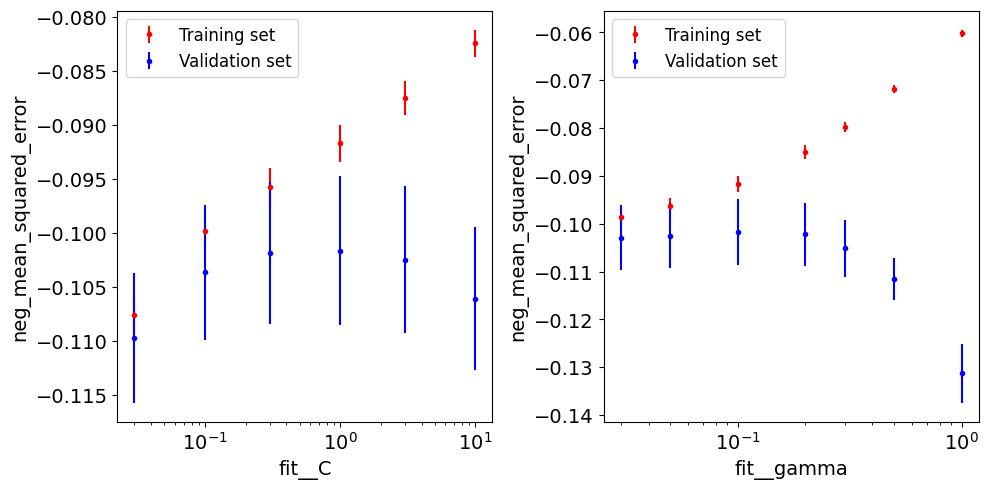

In [52]:
# Visualiza a performance do modelo para diferentes parâmetros:
ml.plot_pars_scores(grid)

Obtemos as seguintes métricas de desempenho para diferentes classes de modelo:

In [53]:
# Ridge: -0.107956
# RF:    -0.105370
# SVR:   -0.101629

In [54]:
# Tabela com desempenho dos hiperparâmeros:
ml.searchCV_table(grid).head()

,mean_fit_time,std_fit_time,param_fit__C,param_fit__gamma,mean_test_score,std_test_score,mean_train_score,std_train_score
23,0.232263,0.026388,1,0.1,-0.101629,0.006889,-0.091709,0.001736
16,0.226533,0.018955,0.3,0.1,-0.101852,0.006612,-0.095709,0.001711
17,0.233238,0.015042,0.3,0.2,-0.102034,0.006188,-0.091553,0.001714
24,0.256501,0.015101,1,0.2,-0.102227,0.006583,-0.084968,0.001467
30,0.289753,0.023320,3,0.1,-0.102466,0.006801,-0.087523,0.001577


### Realizando a medida do efeito causal

Assim como com as simulações, vamos usar k-folds para realizar as estimações evitando possíveis sobreajustes:

In [55]:
do_var = 'VR_RECEITA'
do_values = np.logspace(1, 6, 50)
#do_values = np.arange(1000, 1e6, 1000)

# Initialize KFold with 5 splits:
kf = KFold(n_splits=5, shuffle=True, random_state=42111)

# Loop over data splits:
y_preds = []
for train_index, test_index in kf.split(X_df):
    print('Test set size: ', len(test_index)) # sets must have approx. the same size.
    # Train model:
    X_train, y_train = X_df.iloc[train_index], y_series.iloc[train_index]
    model.fit(X_train, y_train)
    # Predict:
    X_test = X_df.iloc[test_index]
    y_pred = adjustment_predict_intervention(model, X_test, do_var, do_values)
    y_preds.append(y_pred)

y_pred_series = pd.concat(y_preds)
y_pred_final  = y_pred_series.groupby(y_pred_series.index).mean()

Test set size:  555
Test set size:  554
Test set size:  554
Test set size:  554
Test set size:  554


In [56]:
# Ajuste de lei de potência aos dados, diretamente:
pw = ml.PowerLaw(flat_x=True)
dump = pw.fit(clean_df['VR_RECEITA'], clean_df['QT_VOTOS_NOMINAIS_22'])
x_naive = np.logspace(3,6, 40)
y_naive = pw.predict(x_naive)

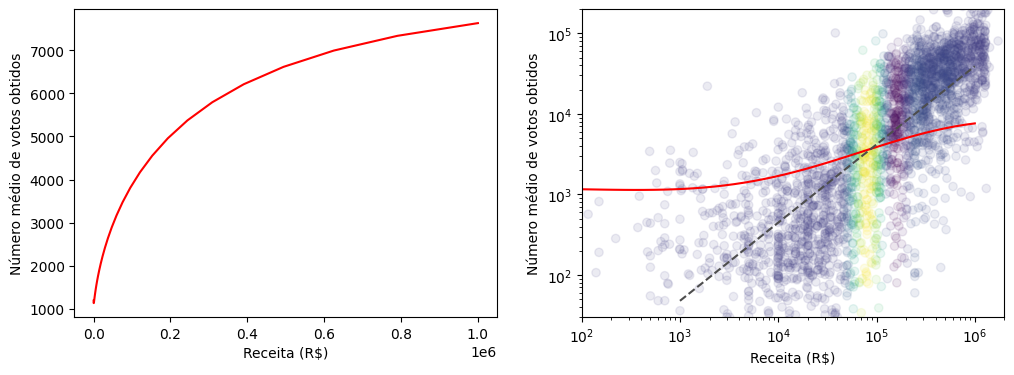

In [58]:
pl.figure(figsize=(12,4))

# PLOT: Efeito médio causal da receita nos votos:
pl.subplot(1,2,1)
pl.plot(y_pred_final.index, 10**y_pred_final.values, color='r')
pl.xlabel('Receita (R$)')
pl.ylabel('Número médio de votos obtidos')

# PLOT: Comparação dos dados e estimativa ingênua direta:
pl.subplot(1,2,2)
xp.density_scatter_plot(clean_df['VR_RECEITA'], clean_df['QT_VOTOS_NOMINAIS_22'], alpha=0.1)
pl.plot(y_pred_final.index, 10**y_pred_final.values, color='r')
pl.plot(x_naive, y_naive, color='0.3', linestyle='--')
pl.yscale('log')
pl.xscale('log')
pl.xlabel('Receita (R$)')
pl.ylabel('Número médio de votos obtidos')
pl.xlim([100, 2e6])
pl.ylim([30, 2e5])

pl.show()

O gráfico da esquerda mostra o efeito causal médio da receita sobre o número de votos obtidos, em escala linear. O gráfico da direita compara a estimativa utilizando a fórmula do ajuste com a estimativa ingênua (ajuste direto entre votos e renda), em escala log-log.